In [1]:
"""
@author: albertigno

"""

from MyLargeDataset import *
import torch, time, os

import torch.nn as nn
import torch.nn.functional as F

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

True
cuda:0


In [13]:
#os.environ['CUDA_VISIBLE_DEVICES'] = "3"
thresh = 0.3
lens = 0.25
decay = 0.9
num_classes = 10
#batch_size = 200 # 128-2048
batch_size = 20 # 4096
learning_rate = 1e-4
#learning_rate = 1e-3 # 128-2048
time_window = 25

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
train_path = r'./../../datasets/nmnist/NMNIST_train_data.mat'
test_path = r'./../../datasets/nmnist/NMNIST_test_data.mat'
# load datasets
print("loading training set...")
train_dataset = MyDataset(train_path, 'nmnist_h', time_window)
print("loading test set...")
test_dataset = MyDataset(test_path, 'nmnist_r')
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=False)

True
cuda:0
loading training set...
num sample: 60000
torch.Size([60000, 2, 34, 34, 50]) torch.Size([60000, 10])
loading test set...
num sample: 10000
torch.Size([10000, 2, 34, 34, 50]) torch.Size([10000, 10])
loading data with pytorch


In [14]:
class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - thresh) < lens
        return grad_input * temp.float() / (2 * lens)

num_hidden = 4096
num_output = 10

best_acc = 0
acc_record = list([])

class SNN_Model(nn.Module):

    def __init__(self, num_classes=10):
        super(SNN_Model, self).__init__()
        
        self.fc_ih = nn.Linear(34*34*2, num_hidden, bias= False)
        self.fc_hh = nn.Linear(num_hidden, num_hidden, bias= False)
        self.fc_ho = nn.Linear(num_hidden, num_output, bias= False)
       
    def forward(self, input, win):
        
        h0_mem = h0_spike = h0_sumspike = torch.zeros(1, batch_size, num_hidden, device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(1, batch_size, num_output, device=device)
        
        for step in range(win):
            
            x = input[:, :, :, :, step]
            x = x.view(1, batch_size, -1)
            
            h0_mem, h0_spike = mem_update_rnn(self.fc_ih, self.fc_hh, x, h0_spike, h0_mem, h0_spike)
                        
            h2_mem, h2_spike = mem_update(self.fc_ho, h0_spike, h2_mem, h2_spike)

            h2_sumspike += h2_spike
        
        outputs = h2_sumspike / (win)
        
        return outputs[0]
       
def mem_update(operation, x, mem, spike):
    mem = mem * decay * (1 - spike) + operation(x)
    spike = act_fun(mem)
    mem = mem*(mem<thresh)
    return mem, spike

def mem_update_rnn(operation1, operation2, x, h, mem, spike):
    a = operation1(x)
    b = operation2(h)
    c = mem * decay * (1 - spike) 
    mem = a + b + c
    spike = act_fun(mem)
    mem = mem*(mem<thresh)
    return mem, spike

In [18]:
def reduce_precision(weights, bits):
    scale = (weights.max()-weights.min())/2
    m = scale*torch.round((weights/scale)*2**bits)/(2**bits)
    return m

snn_state_dict = torch.load('./checkpoint/'+'nmnist_rnn_lsm_{}.t7'.format(num_hidden), map_location=torch.device('cpu'))['net']

base_model = SNN_Model()
base_model.load_state_dict(snn_state_dict)

snn = SNN_Model()

num_epochs = 10

w_hh = base_model.fc_hh.weight.data
w_ih = base_model.fc_ih.weight.data

precision = 1

with torch.no_grad():
    snn.fc_hh.weight.data = torch.nn.Parameter(reduce_precision(w_hh, precision))
    snn.fc_ih.weight.data = torch.nn.Parameter(reduce_precision(w_ih, precision))

modelname = 'nmnist_rwp{}_lsm_{}'.format(precision, num_hidden)

c = 0
for parameter in snn.parameters():
  print(parameter.shape)
  if (c==0 or c==1):
    parameter.requires_grad = False
    print('Frozen')
  c += 1

snn.to(device)

criterion = nn.MSELoss()

def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""

    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.98

    return optimizer

optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

act_fun = ActFun.apply
print(modelname)

torch.Size([4096, 2312])
Frozen
torch.Size([4096, 4096])
Frozen
torch.Size([10, 4096])
nmnist_rwp1_lsm_4096


(-0.5, 29.5, 29.5, -0.5)

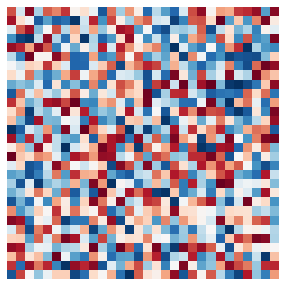

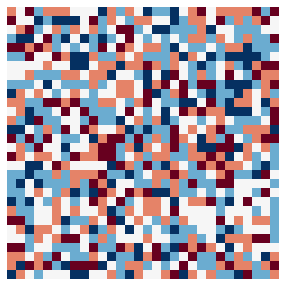

In [19]:
s = 30
uniform = 1/np.sqrt(num_hidden)
c= 'RdBu'
plt.figure(figsize=(5,5))
plt.imshow(w_hh.cpu()[:s,:s], cmap=c, vmin=-uniform, vmax=uniform)
plt.axis('off')
plt.figure(figsize=(5,5))
plt.imshow(snn.fc_hh.weight.data.cpu()[:s,:s], cmap=c, vmin=-uniform, vmax=uniform)
plt.axis('off')
#plt.figure(figsize=(5,5))
#plt.imshow(snn.fc_hh.weight.data.cpu()[:s,:s], cmap=c, vmin=-uniform, vmax=uniform)
#plt.axis('off')
#plt.colorbar()

Epoch [1/10], Step [500/3000], Loss: 26.09986
Time elasped: 36.480912923812866
Epoch [1/10], Step [1000/3000], Loss: 16.86893
Time elasped: 65.90268158912659
Epoch [1/10], Step [1500/3000], Loss: 14.83962
Time elasped: 96.6590883731842
Epoch [1/10], Step [2000/3000], Loss: 13.52802
Time elasped: 126.55671882629395
Epoch [1/10], Step [2500/3000], Loss: 12.86862
Time elasped: 155.4625005722046
Epoch [1/10], Step [3000/3000], Loss: 12.20630
Time elasped: 184.4555947780609
Iters: 0 



Test Accuracy of the model on the test samples: 91.050
Train loss: 96.41133572440594, Test loss: 11.78460004972294
Saving best accuracy so far..
91.05
Epoch [2/10], Step [500/3000], Loss: 11.59690
Time elasped: 37.51859998703003
Epoch [2/10], Step [1000/3000], Loss: 11.24437
Time elasped: 66.78436493873596
Epoch [2/10], Step [1500/3000], Loss: 10.80333
Time elasped: 96.283123254776
Epoch [2/10], Step [2000/3000], Loss: 10.99690
Time elasped: 125.49291253089905
Epoch [2/10], Step [2500/3000], Loss: 10.90311
T

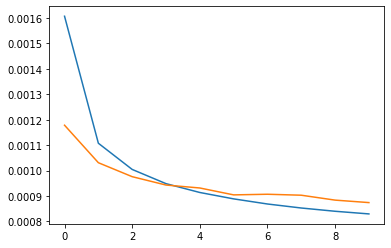

In [20]:
win = 25
best_acc = 0
train_loss = []
test_loss = []

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

for epoch in range(num_epochs):
    running_loss = 0
    total_loss_train = 0
    start_time = time.time()
    total = 0

    for i, (images, labels) in enumerate(train_loader):

        snn.zero_grad()
        optimizer.zero_grad()

        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = snn(images, win)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        total_loss_train += loss.item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        if (i + 1) % 500 == 0:
            # print( outputs.sum(dim=0) )
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.5f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, running_loss))
            running_loss = 0
            print('Time elasped:', time.time() - start_time)
    train_loss.append(total_loss_train / total)

    optimizer = lr_scheduler(optimizer, epoch, learning_rate, 1)

    correct = 0
    total = 0
    total_loss_test = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = snn(images, win)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        _, reference = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == reference).sum()
        total_loss_test += loss.item() 

    print('Iters:', epoch, '\n\n\n')
    print('Test Accuracy of the model on the test samples: %.3f' % (100 * correct.float() / total))

    print('Train loss: {}, Test loss: {}'.format(total_loss_train, total_loss_test))

    acc = 100. * float(correct) / float(total)
    acc_record.append(acc)

    test_loss.append(total_loss_test / total)
    state = {
    'net': snn.state_dict(),
    'acc': acc,
    'epoch': epoch,
    'acc_record': acc_record,
    'train_loss': train_loss,
    'test_loss': test_loss
    }    

    if acc>best_acc:
        print('Saving best accuracy so far..')
        print(acc)
        torch.save(state, './checkpoint/' + modelname + '.t7',  _use_new_zipfile_serialization=False)
        best_acc = acc
    else:
        torch.save(state, './checkpoint/' + modelname + '_final.t7',  _use_new_zipfile_serialization=False)
        
state = {
'net': snn.state_dict(),
'acc': acc,
'epoch': epoch,
'acc_record': acc_record,
'train_loss': train_loss,
'test_loss': test_loss
}    

mf = modelname.split('.')[0] + '_final.t7'
torch.save(state, './checkpoint/' + mf ,  _use_new_zipfile_serialization=False)
plt.plot(train_loss)
plt.plot(test_loss)

import torch
import numpy as np
import os

print("loading trained model")

modelname = modelname+'.t7'
model_to_load = modelname

#snn_state_dict = torch.load('./checkpoint/'+modelname, map_location=torch.device('cpu'))['net']
snn_state_dict = torch.load('./checkpoint/'+model_to_load, map_location=torch.device('cpu'))['net']
print(snn_state_dict.keys())

layers_location = 'checkpoint/'+model_to_load.split('.')[0]

if not os.path.isdir(layers_location):
    os.mkdir(layers_location)

weights_biases = []
for k in snn_state_dict:
    np.savez(layers_location+'/'+k,snn_state_dict[k].data.cpu().numpy())
    weights_biases.append(snn_state_dict[k].data.cpu().numpy())

In [19]:
def get_accuracy(model):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        outputs = model(images, win)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    
    acc = 100 * correct.float() / total
    return acc

acc = get_accuracy(model)

print('Test Accuracy of the model on the 10000 test images: %.3f' % (acc))

Test Accuracy of the model on the 10000 test images: 70.264


In [17]:
model_to_load = modelname
#model_to_load = 'heidelberg_rnn_400_mem1.t7'
snn_state_dict = torch.load('./checkpoint/'+model_to_load, map_location=torch.device('cpu'))['net']

model = SNN_Model()
model.load_state_dict(snn_state_dict)
model.to(device)
model.eval()

num_to_test = 50
for images, labels in test_loader:
    images = images.float().to(device)
    labels = labels.float().to(device)
    outputs = model(images, win)
    _, predicted = torch.max(outputs[:num_to_test,:].data, 1)
    _, reference = torch.max(labels[:num_to_test,:].data, 1)
    correct = (predicted == reference).sum()
    break

print('Test Accuracy of the model on the 10000 test images: %.3f' % (100 * correct.float() / num_to_test))

Test Accuracy of the model on the 10000 test images: 66.000


#### SpiNNaker: 50 muestras, 58%